# Transition path theory tutorial

***This notebook is not complete!***

In this tutorial, we will introduce and illustrate some basic ideas behind **transition path theory (TPT)**, which is used to compute statistics on *ensembles* of reactive trajectories (which we will call **transitions**) between macrostates in the state space. We will need the following Julia packages:

In [1]:
using Random, Distributions, StatsBase, StatsPlots
using LinearAlgebra, ApproxFun, DifferentialEquations
using Plots, LaTeXStrings

We might also use this propagator operation from the operator exponential [tutorial](https://github.com/mjyshin/math-tutorials/blob/main/operator_exponential.ipynb). (We pick this one instead of the [alternative](https://github.com/mjyshin/math-tutorials/blob/main/alternate_exponential.ipynb), since our operators are not self-adjoint.)

In [2]:
import Base: exp

function exp(L::Operator,B::Operator,t::Real,u0::Fun,n::Integer)
    C = Conversion(domainspace(L),rangespace(L))
    
    perm = [3;2;1;4:n]
    P = I(n)[:,perm]    # permutation matrix
    
    B = B[1:2,1:n]*P    # permuted BCs
    B = B[1:2,1:2]\B    # Gaussian eliminated BCs
    M = C[1:n-2,1:n]*P    # permuted masses
    M = M - M[:,1:2]*B    # remove d.o.f.
    L = L[1:n-2,1:n]*P    # permuted generator
    L = L - L[:,1:2]*B    # remove d.o.f.
    A = M[:,3:n]\L[1:n-2,3:n]    # BC-merged generator
    
    c = P'*u0.coefficients[1:n]    # permuted coeffs
    c0 = exp(A*t)*c[3:n]    # interior coeffs, Eq. (3)
    ∂c = B*c - B[:,3:n]*c0    # BC coeffs
    
    c = P*[∂c;c0]    # de-permuted coeffs
    u = chop(Fun(domain(u0),c))
    
    return u
end

exp(L::Operator,B::Operator,t::Real,u0::Fun) = exp(L,B,t,u0,ncoefficients(u0))
exp(L::Operator,B::Operator,t::Real,u0::Fun,tol::Real) = exp(L,B,t,u0,ncoefficients(chop(u0,tol)))

exp (generic function with 40 methods)

Before we venture into the nomenclature of ₊, we should review some useful notions from stochastic processes in 1D, namely the forward and backward generators of the process (as we will use them quite a bit).

## Background on stochastic processes

We define a one-parameter semigroup of operators (called the **Markov semigroup**) on an arbitrary *bounded* observable $f$ on the stochastic process $X_t\in\Omega:=\mathbb{R}$ (this is sloppy notation) as the conditional expectation

$$
(T_tf)(x) := \mathbb{E}[f(X_t)\vert X_0 = x]
$$

with the identity $I=T_0$ and the infinitesimal generator of $T_t$

$$
\mathcal{L}f := \lim_{t\to 0^+}\frac{T_tf - f}{t}.
$$

If we define a time dependent function $u(x,t) := (T_tf)(x)$, we can easily derive that $u$ observes the PDE (called the **backward Kolmogorov equation (BKE)**)

$$
\begin{align*}
\frac{\partial u}{\partial t} &= \mathcal{L}u\\
u(x,0) &= f(x)
\end{align*}\label{eq:bke}\tag{1}
$$

by using the chain rule and the fact that $T_t = e^{t\mathcal{L}}$ by the general property of semigroups of operators. We can therefore think of the KBE as the dynamics of arbitrary *moments* of the process $X_t$. If we expand $u(x,t) = \int_\Omega f(x)\rho(x,t)\,\text{d}x$ and apply $T_t$ to $f$ we get

$$
\int_\Omega(T_tf)(x)\rho(x,t)\,\text{d}x = \int_\Omega f(x)(T_t^\ast\rho)(x,t)\,\text{d}x,
$$

where $T_t^\ast$ is the formal adjoint of $T_t$ with generator $\mathcal{L}^\ast$ (which is the adjoint of $\mathcal{L}$) that observes the PDE (called the **forward Kolmogorov equation (FKE)**) on the probability density $\rho$ of the process $X_t$:

$$
\begin{align*}
\frac{\partial\rho}{\partial t} &= \mathcal{L}^\ast\rho\\
\rho(x,0) &= \rho_0(x),
\end{align*}\label{eq:fke}\tag{2}
$$

given some initial density $\rho_0$. For a (time-)homogeneous diffusion process with drift, the above FKE is the famous **Fokker-Planck equation (FPE)** where we have the functional form

$$
\mathcal{L}^\ast = -\frac{\partial}{\partial x}\left(\mu(x)\,\cdot\right) + \frac{1}{2}\frac{\partial^2}{\partial x^2}\left(\sigma(x)^2\,\cdot\right).
$$

Using integration by parts on $\langle f,\mathcal{L}^\ast\rho \rangle = \langle \mathcal{L}f,\rho \rangle$ (and the fact that $f$ is bounded, therefore disappearing on $\partial\Omega$), we arrive at the functional form of the KBE for the diffusion process with drift:

$$
\mathcal{L} = \mu(x)\frac{\partial}{\partial x} + \frac{1}{2}\sigma(x)^2\frac{\partial^2}{\partial x^2}.
$$

### Mathematical model

Let's illustrate this with a simple case of overdamped dynamics on a double-well potential and constant noise

$$
\mu(x) := -V'(x),\quad \sigma(x) := \sqrt{2D},
$$

where $V(x) = \frac{1}{\epsilon}\left(\frac{x^4}{4} - \frac{x^2}{2} - \alpha x\right)$ is the potential function and $D$ is the diffusion constant. We'll let $\epsilon=0.1$ and $\alpha=0.1$ for concreteness. Let's visualize $V$, noting that it does not depend on $D$:

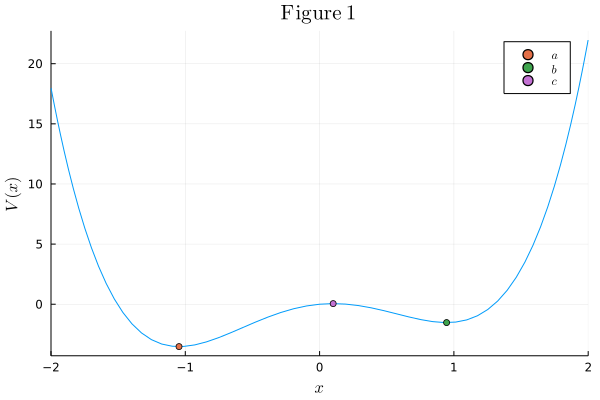

In [3]:
ϵ,α = 0.1,0.1
xmin,xmax = -2,2
Ω = Chebyshev(xmin..xmax)
V = Fun(x->(x^4/4 - x^2/2 + α*x)/ϵ,Ω)
a,c,b = roots(V')

xlims = (xmin,xmax)
fig = plot(V,title=L"\textrm{Figure\ 1}",label=false,fmt=:png)
fig = scatter!([a],[V(a)],label=L"a",xlims=xlims)
fig = scatter!([b],[V(b)],label=L"b",xlabel=L"x")
fig = scatter!([c],[V(c)],label=L"c",ylabel=L"V(x)")

From Fig. 1, we can imagine that the process $X_t$ would jump between the two wells (called **metastable states**) centered around $x=a\approx-1$ and $x=b\approx1$ due to the diffusive noise, but generally spend more time in the former well due to its lower energy (unless the noise absolutely dominates the dynamics). To see this more clearly, let's simulate one such trajectory of $X_t$.

The corresponding SDE for this process is

$$
\begin{align*}
\text{d}X_t &= \underbrace{-V'(X_t)}_{\mu(X_t,t)}\,\text{d}t + \underbrace{\sqrt{2D}}_{\sigma(X_t,t)}\,\text{d}W_t\\
X_0 &= x_0,
\end{align*}\label{eq:sde}\tag{3}
$$

where $W_t$ is the standard Wiener process with $\text{d}W_t \sim \mathcal{N}(0,\text{d}t)$.

In [4]:
μ(x,θ,t) = -(x^3 - x + θ.α)/θ.ϵ
σ(x,θ,t) = √(2θ.D)

σ (generic function with 1 method)

We'll also set the diffusion at $D=2$ and run the SDE in the time domain $\mathbb{T}=[0,100]$ from the initial state $x_0=0$.

In [5]:
D = 2
θ = (ϵ=ϵ,α=α,D=D)
tspan = (0.0,100.0)
x0 = 0

0

We can sample from Eq. ([3](#mjx-eqn-eq:sde)) and plot the trajectory as a function of time:

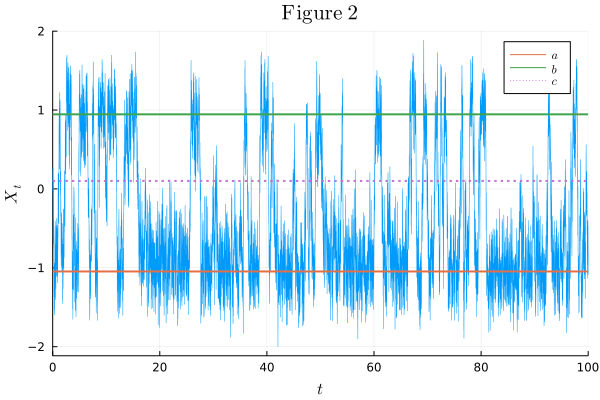

In [6]:
Random.seed!(1)
prob = SDEProblem(μ,σ,x0,tspan,θ)
x = solve(prob)

fig = plot(x,width=0.5,label=false)
fig = hline!([a],width=2,label=L"a",xlabel=L"t",ylabel=L"X_t")
fig = hline!([b],width=2,label=L"b",title=L"\textrm{Figure\ 2}")
fig = hline!([c],width=2,style=:dot,label=L"c",fmt=:png)

Just as we intuitively predicted, $X_t$ seems to "prefer" the left well around $x=a$. Broadly speaking, we can consider going from the left well to the right to be a "rare transition".

## Introduction to transition path theory

As we introduced in the very beginning, TPT is a formalism to compute useful statistics on "transitions", which we will now formally define. There are lots of terms, so try not to get too flustered if it's a bit confusing at first!

The first question we ask is: *Where is this transition to and from?* To answer this, we will define two macrostates in $\Omega$ to the left of the left well and to the right of the right well in Fig 1.

$$
A := \{x\in\Omega:x\leq a\},\quad B := \{x\in\Omega\setminus A:x\geq b\},
$$

as well as two functions on $\mathbb{T}$ denoting *when $X_t$ was last at $A$/$B$* and *when $X_t$ will next be at $A$/$B$*:

$$
\tau_0(t) := \sup\{\tau\leq t:X_\tau\in A\cup B\},\quad \tau_f(t) := \inf\{\tau\geq t:T_\tau\in A\cup B\}.
$$

Note that if $X_t\in A\cup B$, then $\tau_0(t)=\tau_f(t)=t$. Finally, we also define a **reaction** (or "reactive trajectory" or "transition") to be a path that *begins at $A$* and *ends at $B$*. Then we can call

$$
\mathcal{X}_R := \{X_t\in\Omega\setminus(A\cup B):t\in \mathbb{T}_R\}
$$

the *ensemble* of reactive trajectories, where

$$\mathbb{T}_R := \{t\in\mathbb{T}:X_{\tau_0(t)}\in A,X_{\tau_f(t)}\in B\}$$

is the set of times that $X_t$ is undergoing a reaction. (In layman's term, the first condition simply says $X_t$ came from $A$, and the second condition that $X_t$ is going to $B$.) By this definition, trajectories that *don't* count as transitions are those that go from $A$ to $A$, from $B$ to $B$, and from $B$ to $A$. As such, we would define sets $A$ and $B$ to be macrostates of interest, depending on the application at hand.

Now that we have that out of the way, let's briefly introduce three statistics we can compute on $\mathcal{X}_R$:

- Reactive trajectory $\pi_R$, describing the equilibrium density of $X_t\in\mathcal{X}_R$,
- Reactive flux $\textbf{j}_R$, describing the current/flow through a dividing surface out of $A$ towards $B$, and
- Reaction rate $r_R$, describing how "quickly" a typical transition takes place.

In order to compute these, however, we need three auxiliary functions: the equilibrium density $\pi$, forward committor $q_+$, and backward committor $q_-$. In the next six subsections, we will go over the definitions of and compute these six functions.

### Equilibrium density

As stated above, the probability density of the process $X_t$ follows the FKE ([2](#mjx-eqn-ex:fke)). Let's get the adjoint generator in a friendlier form for numerical computation. Using the chain rule, we get

$$
\begin{align*}
\mathcal{L}^\ast &= \frac{\partial}{\partial x}\left(V'\,\cdot\right) + D\frac{\partial^2}{\partial x^2}\\
&= V'' + V'\frac{\partial}{\partial x} + D\frac{\partial^2}{\partial x^2}.
\end{align*}
$$

The BCs are $\rho(x,t)\xrightarrow{x\to\pm\infty}0$ as we have the normalization constraint $\int_\Omega\rho(x,t)\,\text{d}x=1$, but since the potential $V(x)$ is already pretty high at $\lvert x \rvert>2$, we will set Dirichlet BCs at those "numerical boundaries". Since we are interested in the long-term behavior of the density $\rho$, we can arbitrarily set the initial density $\rho_0$ as, say, $x\sim\mathcal{N}(\mu_0,\sigma_0^2)$.

In [7]:
𝒟x = Derivative(Ω)
ℒᵀ = V'' + V'*𝒟x + D*𝒟x^2
ℬ = [ldirichlet(Ω);rdirichlet(Ω)]
∑ = DefiniteIntegral(Ω)
μ0,σ0 = 0,0.5
ρ0 = Fun(x->1/√(2π*σ0^2)*exp(-(x-μ0)^2/(2σ0^2)),Ω)

Fun(Chebyshev(-2..2),[0.16516363700114997, 0.0, -0.2852450701390882, 0.0, 0.18770473893275585, 0.0, -0.09754033120633235, 0.0, 0.041394242123257326, 0.0  …  0.0, 1.4755281862849331e-12, 0.0, -1.5371685739927202e-13, 0.0, 1.522613686079408e-14, 0.0, -1.4481681006350594e-15, 0.0, 1.307480057381738e-16])



$$
\begin{align*}
\mathcal{L}^\ast\pi &= 0,\quad x\in\Omega\\
\pi(x) &= 0,\quad x\in\partial\Omega\\
\int_\Omega\pi(x)\,\text{d}x &= 1
\end{align*}\label{eq:eqdens}\tag{4}
$$

The analytical solution to the above equilibrium FKE is the Gibbs measure of $X_t$ at thermal equilibrium

$$
\pi(x) = Z^{-1}e^{-\frac{V(x)}{D}},
$$

where $Z = \int_\Omega e^{-\frac{V(x)}{D}}\,\text{d}x$ is the partition function

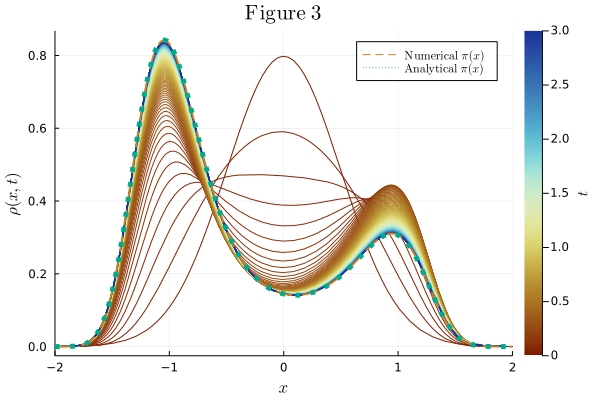

In [8]:
t = 0:0.02:3
ρ = exp.(Ref(ℒᵀ),Ref(ℬ),t,Ref(ρ0))    # PDE solution
#πⁿ = [∑;ℬ;ℒᵀ]\[1;0;0;0]    # computationally very expensive
πⁿ = [ℬ;ℒᵀ]\[eps();eps();0]    # numerical w/o normalization
πⁿ = πⁿ/sum(πⁿ)    # normalization constraint
πᵃ = exp(-V/D)/sum(exp(-V/D))    # analytical solution

fig = plot(xlims=xlims,xlabel=L"x",ylabel=L"\rho(x,t)",title=L"\textrm{Figure\ 3}")
fig = plot!(ρ,line_z=t',color=:roma,cbar=true,cbartitle=L"t",label=false,fmt=:png)
fig = plot!(πⁿ,width=2,style=:dash,label=L"\textrm{Numerical\ }\pi(x)")
fig = plot!(πᵃ,width=5,style=:dot,label=L"\textrm{Analytical\ }\pi(x)")

What does this tell us? The equilibrium density $\pi(x)$ is the long-run (i.e., as $\mathbb{T}\to\mathbb{R}_+$) probability density for finding the diffusion process $X_t$ at $[x,x+\text{d}x)$.

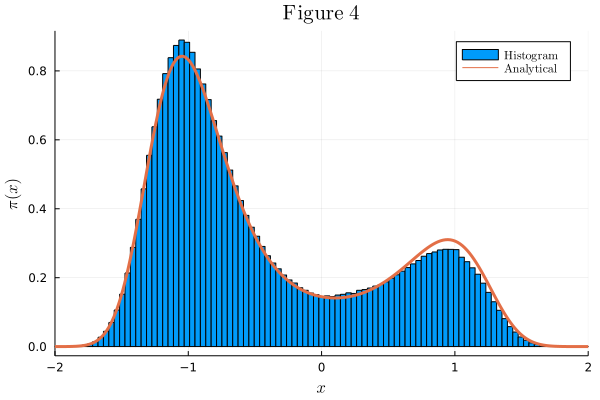

In [91]:
Random.seed!(2)
Δt = 1e-4
bins = range(xmin,xmax,100)
X = solve(remake(prob,tspan=(0.0,1000.0)),maxiters=Int(1e7),saveat=Δt)
h1 = normalize(fit(Histogram,X.u,bins))

fig = plot(xlabel=L"x",ylabel=L"\pi(x)",title=L"\textrm{Figure\ 4}")
fig = plot!(h1,label=L"\textrm{Histogram}",xlims=xlims,fmt=:png)
fig = plot!(πᵃ,width=3,label=L"\textrm{Analytical}")

Put in another light, we can also think of it as the probability density of the unrestricted *ensemble* of all trajectories $\mathcal{X}:=\{X_t\in\Omega,t\in\mathbb{T}\}$.

#### Brief interlude in sampling

In [10]:
function rejection(f::Fun,N::Int)
    Ω = domain(f)
    a,b = Ω.left,Ω.right
    M = maximum(f)
    X = []
    while length(X) < N
        x = rand(Uniform(a,b))
        r = rand(Uniform(0,M))
        if r < f(x) push!(X,x) end
    end
    return X
end

function metropolis(f::Fun,N::Int,σ::Real)
    Ω = domain(f)
    a,b = Ω.left,Ω.right
    X = [rand(Uniform(a,b))]
    while length(X) < N
        x = X[end]
        y = x + rand(Normal(0,σ))
        if y ∈ Ω
            α = f(y)/f(x)
            if rand() < α push!(X,y)
            else push!(X,x) end
        else push!(X,x) end
    end
    return X
end

Random.seed!(3)
M,N = 100,Int(1e4)
@time begin for i ∈ 1:M rejection(πⁿ,N) end end
@time begin for i ∈ 1:M metropolis(πⁿ,N,0.5) end end

  8.678708 seconds (23.25 M allocations: 664.082 MiB, 6.56% gc time, 83.58% compilation time)
  0.332477 seconds (137.81 k allocations: 38.970 MiB, 34.76% compilation time)


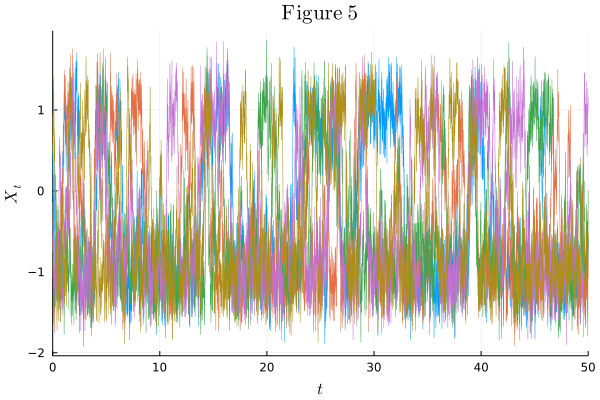

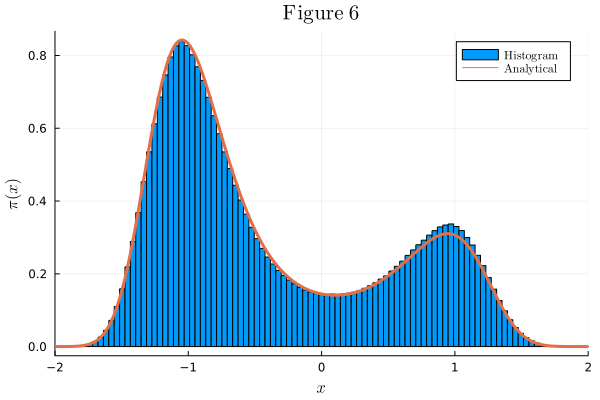

In [92]:
Random.seed!(4)
n,tf = 100,50.0
#X0 = metropolis(πⁿ,n,0.5)
X0 = rand(Uniform(xmin,xmax),n)
𝒳 = [solve(remake(prob,u0=X0[i],tspan=(0.0,tf)),saveat=Δt).u for i ∈ 1:n]
hn = normalize(merge(fit.(Ref(Histogram),𝒳,Ref(bins))...))

fig = plot(xlabel=L"t",ylabel=L"X_t",title=L"\textrm{Figure\ 5}")
fig = plot!(0:Δt:tf,𝒳[1:5],width=0.5,label=false,xlims=(0,tf),fmt=:png)
display(fig)

fig = plot(xlabel=L"x",ylabel=L"\pi(x)",title=L"\textrm{Figure\ 6}")
fig = plot!(hn,label=L"\textrm{Histogram}",xlims=xlims,fmt=:png)
fig = plot!(πᵃ,width=3,label=L"\textrm{Analytical}")
display(fig)

### Forward committor

In [12]:
Ωᴿ = Chebyshev(a..b)    # Ω\(A∪B)
Vᴿ = Fun(x->(x^4/4 - x^2/2 + α*x)/ϵ,Ωᴿ)    # V(x) in Ω\(A∪B)
𝒟xᴿ = Derivative(Ωᴿ)    # 𝒟ₓ in Ω\(A∪B)
ℒ = -Vᴿ'*𝒟xᴿ + D*𝒟xᴿ^2
ℬᴿ = [ldirichlet(Ωᴿ);rdirichlet(Ωᴿ)]    # BCs at ∂A and ∂B

InterlaceOperator : Chebyshev(-1.0466805318046002..0.9456492739235907) → 2-element ArraySpace:
ConstantSpace{DomainSets.Point{Float64}, Float64}[ConstantSpace(Point(-1.0466805318046002)), ConstantSpace(Point(0.9456492739235907))]
 1.0  -1.0  1.0  -1.0  1.0  -1.0  1.0  -1.0  1.0  -1.0  ⋯
 1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0  1.0   1.0  ⋯

$$
\begin{align*}
\mathcal{L}q_+ &= 0,\quad x\in\Omega\setminus(A\cup B)\\
q_+(x) &= 0,\quad x\in\partial A:=\{a\}\\
q_+(x) &= 1,\quad x\in\partial B:=\{b\}
\end{align*}\label{eq:fcomm}\tag{5}
$$

The analytical solution to the equation above is the quadrature

$$
q_+(x) = C^{-1}\int_a^xe^{\frac{V(\xi)}{D}}\,\text{d}\xi,
$$

where $C = \int_a^be^{\frac{V(\xi)}{D}}\,\text{d}\xi$ is the normalizing constant for the total probability.

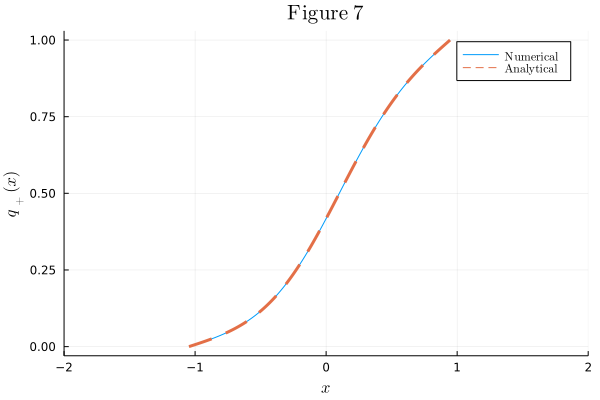

In [95]:
#u0 = Fun(x->(tanh(10^1*(x-b)) + 1)/2,Ωᴿ)
#=u0 = Fun(x->(x*(x-a)*(x-b) + (x-a))/2,Ωᴿ)
t = 0:0.1:1
u = exp.(Ref(ℒ),Ref(ℬᴿ),t,Ref(u0))=#

q₊ⁿ = [ℬᴿ;ℒ]\[0;1;0]
q₊ᵃ = cumsum(exp(Vᴿ/D))/sum(exp(Vᴿ/D))

fig = plot(xlabel=L"x",ylabel=L"q_+(x)",title=L"\textrm{Figure\ 7}")
#fig = plot!(u,line_z=t',color=:roma,cbar=true,cbartitle=L"t",label=false)
fig = plot!(q₊ⁿ,label=L"\textrm{Numerical}",xlims=xlims,fmt=:png)
fig = plot!(q₊ᵃ,width=3,style=:dash,label=L"\textrm{Analytical}")

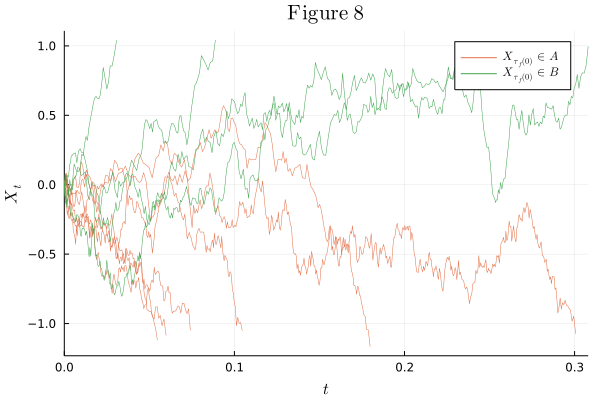

In [99]:
Random.seed!(5)
condition(u,t,integrator) = u[1] ≤ a || u[1] ≥ b
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition,affect!)

X₊ = [solve(prob,callback=cb) for i ∈ 1:10]
t₊A,t₊B = [],[]
X₊A,X₊B = [],[]
for x₊ ∈ X₊
    if x₊[end] ≤ a
        push!(t₊A,x₊.t)
        push!(X₊A,x₊.u)
    elseif x₊[end] ≥ b
        push!(t₊B,x₊.t)
        push!(X₊B,x₊.u)
    end
end

t₊f = maximum(maximum.([t₊A;t₊B]))
labelA = permutedims([L"X_{\tau_f(0)} \in A";repeat([false],max(length(X₊A)-1,0))])
labelB = permutedims([L"X_{\tau_f(0)} \in B";repeat([false],max(length(X₊B)-1,0))])
fig = plot(xlims=(0,t₊f),xlabel=L"t",ylabel=L"X_t",title=L"\textrm{Figure\ 8}")
fig = plot!(t₊A,X₊A,width=0.5,color=palette(:default)[2],label=labelA,fmt=:png)
fig = plot!(t₊B,X₊B,width=0.5,color=palette(:default)[3],label=labelB)

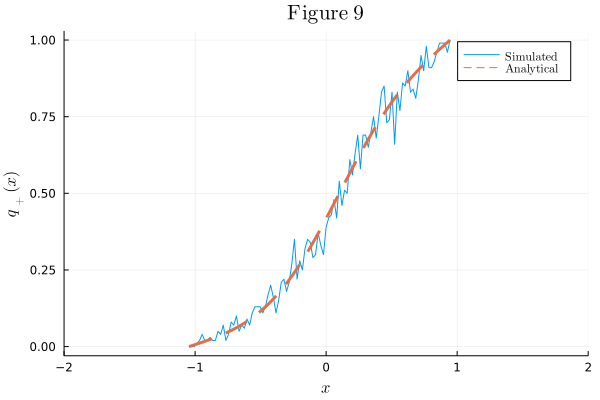

In [100]:
function q̂₊(x::Real,a::Real,b::Real,n::Int,prob::SDEProblem,cb::DiscreteCallback)
    xf = [solve(remake(prob,u0=x),callback=cb)[end] for i ∈ 1:n]
    nA = sum(xf .≤ a)
    nB = sum(xf .≥ b)
    return nB/(nA+nB)
end

X₊0 = range(a,b,100)
Q̂₊ = [q̂₊(x₊0,a,b,n,prob,cb) for x₊0 ∈ X₊0]
fig = plot(X₊0,Q̂₊,xlims=xlims,xlabel=L"x",ylabel=L"q_+(x)",label=L"\textrm{Simulated}",fmt=:png)
fig = plot!(q₊ᵃ,width=3,style=:dash,label=L"\textrm{Analytical}",title=L"\textrm{Figure\ 9}")

### Backward committor

$$
\mathcal{L}^-f := \lim_{t\to0^+}\frac{T_{-t}f-f}{t}
$$

$$
\mathcal{L}^-f = \frac{1}{\pi}\mathcal{L}^\ast(\pi f)
$$

$$
\begin{align*}
\pi\mathcal{L}^- &= \frac{\partial}{\partial x}\left(V'\pi\,\cdot\right) + D\frac{\partial^2}{\partial x^2}(\pi\,\cdot)\\
&= (V'\pi)' + V'\pi\frac{\partial}{\partial x} + D\frac{\partial}{\partial x}\left(\pi'\,\cdot + \pi\frac{\partial}{\partial x}\,\cdot\right)\\
&= V''\pi + V'\pi' + V'\pi\frac{\partial}{\partial x} + D\left[ \pi'' + 2\pi'\frac{\partial}{\partial x} + \pi\frac{\partial^2}{\partial x^2}\right].
\end{align*}
$$

In [24]:
πᴿⁿ = Fun(x->πⁿ(x),Ωᴿ)    # numerical π(x) in Ω\(A∪B)
ℒ⁻ = Vᴿ'' + Vᴿ'*πᴿⁿ'/πᴿⁿ + Vᴿ'*𝒟xᴿ + D*(πᴿⁿ''/πᴿⁿ + 2πᴿⁿ'/πᴿⁿ*𝒟xᴿ + 𝒟xᴿ^2)
ℒᵀᴿ = Vᴿ'' + Vᴿ'*𝒟xᴿ + D*𝒟xᴿ^2    # ℒ* in Ω\(A∪B)

PlusOperator : Chebyshev(-1.0466805318046002..0.9456492739235907) → Ultraspherical(2,-1.0466805318046002..0.9456492739235907)
 -4.961722568491195    0.7548284489495669   …    ⋅                   ⋅
 -0.7548284489495489  -1.2404306421228055        ⋅                   ⋅
  2.4808612842455835  -0.37741422447477446       ⋅                   ⋅
   ⋅                   1.2404306421227917      -1.2404306421227915   ⋅
   ⋅                    ⋅                       0.37741422447477446  ⋱
   ⋅                    ⋅                   …   2.4808612842455977   ⋱
   ⋅                    ⋅                      -1.1322426734243414   ⋱
   ⋅                    ⋅                      36.27772361620315     ⋱
   ⋅                    ⋅                       1.1322426734243414   ⋱
   ⋅                    ⋅                      -2.4808612842455973   ⋱
   ⋅                    ⋅                   …    ⋱                   ⋱

$$
\begin{align*}
\mathcal{L}^-q_- &= 0,\quad x\in\Omega\setminus(A\cup B)\\
q_-(x) &= 1,\quad x\in\partial A\\
q_-(x) &= 0,\quad x\in\partial B
\end{align*}\label{eq:bcomm1}\tag{6}
$$

$$
\begin{align*}
\mathcal{L}^\ast\pi q_- &= 0,\quad x\in\Omega\setminus(A\cup B)\\
(\pi q_-)(x) &= \pi(x),\quad x\in\partial A\\
(\pi q_-)(x) &= 0,\quad x\in\partial B
\end{align*}\label{eq:bcomm2}\tag{7}
$$

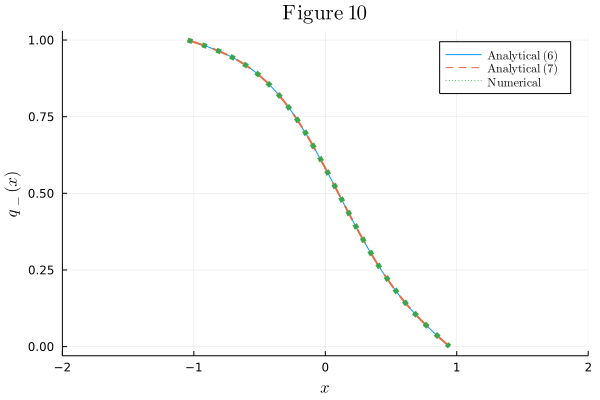

In [77]:
q₋ⁿ¹ = [ℬᴿ;ℒ⁻]\[1;0;0]
q₋ⁿ² = ([ℬᴿ;ℒᵀᴿ]\[πᴿⁿ(a);0;0])/πᴿⁿ
q₋ᵃ = 1 - q₊ᵃ

fig = plot(xlabel=L"x",ylabel=L"q_-(x)",title=L"\textrm{Figure\ 10}")
fig = plot!(q₋ⁿ¹,label=L"\textrm{Analytical\ (6)}",xlims=xlims,fmt=:png)
fig = plot!(q₋ⁿ²,width=2,style=:dash,label=L"\textrm{Analytical\ (7)}")
fig = plot!(q₋ᵃ,width=5,style=:dot,label=L"\textrm{Numerical}")

### Reactive density

$$
\pi_R(x) := Z_R^{-1}\pi(x)\,q_-(x)\,q_+(x),\quad x\in\Omega\setminus(A\cup B)
$$

where $Z_R = \int_{\Omega\setminus(A\cup B)}\pi(x)\,q_-(x)\,q_+(x)\,\text{d}x$ is the normalizing constant for the probability density such that $\int_{\Omega\setminus(A\cup B)}\pi_R(x)\,\text{d}x = 1$.

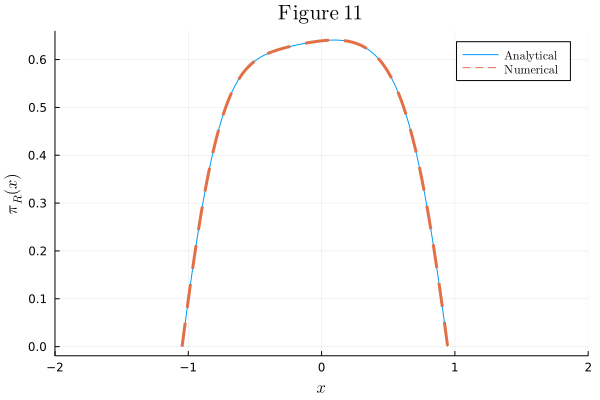

In [97]:
q₋ⁿ = q₋ⁿ¹
πᵣⁿ = πᴿⁿ*q₋ⁿ*q₊ⁿ
πᵣⁿ = πᵣⁿ/sum(πᵣⁿ)

πᴿᵃ = Fun(x->πᵃ(x),Ωᴿ)
πᵣᵃ = πᴿᵃ*q₋ᵃ*q₊ᵃ
πᵣᵃ = πᵣᵃ/sum(πᵣᵃ)

fig = plot(xlabel=L"x",ylabel=L"\pi_R(x)",title=L"\textrm{Figure\ 11}")
fig = plot!(πᵣⁿ,label=L"\textrm{Analytical}",xlims=xlims,fmt=:png)
fig = plot!(πᵣᵃ,width=3,style=:dash,label=L"\textrm{Numerical}")

Given the measure $\pi_R$ we can ask questions like: In the long run, what proportion of time does a transition spend at some (measurable) set $S\subseteq\Omega\setminus(A\cup B)$? The answer to which is

$$
\mathbb{P}\{X_t\in S:X_t\in\mathcal{X}_R\} = \int_S\pi_R(x)\,\text{d}x.
$$

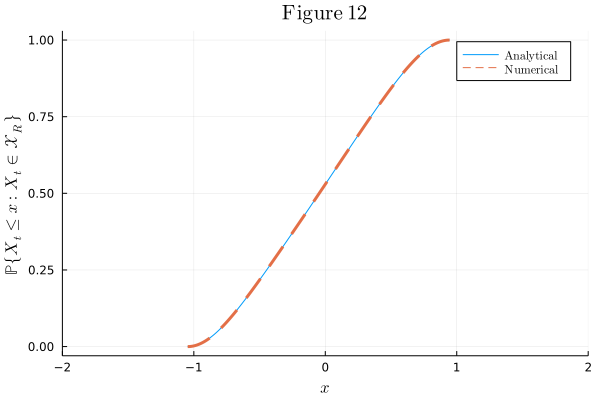

In [98]:
∫πᵣⁿ = cumsum(πᵣⁿ)
∫πᵣᵃ = cumsum(πᵣᵃ)

fig = plot(ylabel=L"\mathbb{P}\{X_t\leq x:X_t\in\mathcal{X}_R\,\}",title=L"\textrm{Figure\ 12}")
fig = plot!(∫πᵣⁿ,label=L"\textrm{Analytical}",xlabel=L"x",xlims=xlims,fmt=:png)
fig = plot!(∫πᵣᵃ,width=3,style=:dash,label=L"\textrm{Numerical}")

### Reactive current